# Analysis of Wilson loop means
## Import
### Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit
from tqdm import tqdm_notebook
sns.set_style("whitegrid")

### Data

In [2]:
PATH = '../Output/'

In [3]:
data = pd.DataFrame()
for i, result in tqdm_notebook(enumerate(glob.glob(f'{PATH}*.csv'))):
    if i == 0:
        data = pd.read_csv(result, names=['R', 'T', f'W_{i}'], header=0)
    else:
        try:
            data[f'W_{i}'] = pd.read_csv(result, usecols=['Mean'])['Mean'].values.astype(np.float64)
        except pd.io.common.EmptyDataError:
            print(f'{result} is empty')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [4]:
split = [y for y in data.columns if 'W_' in y]
data['Ws'] = list(data[split].values)
data.drop(columns=split, inplace=True)

In [5]:
data.head()

,R,T,Ws
0,1,1,"[0.6133695100095117, 0.6139145105375342, 0.613..."
1,1,2,"[0.4096131012683888, 0.41058232075961476, 0.41..."
2,1,3,"[0.2788509674644183, 0.28000707642180395, 0.27..."
3,1,4,"[0.19086266539196164, 0.19185265506626395, 0.1..."
4,1,5,"[0.1307019700130703, 0.13184293829318722, 0.13..."


## Jackknife

In [6]:
def jackknife(ws):
    ws_sum = np.sum(ws)
    jk = np.zeros_like(ws)
    n = len(ws)
    
    for i in range(n):
        jk[i] = (ws_sum-ws[i])
    jk /= n-1
    
    mean = np.mean(jk)
    std = np.sqrt((len(jk)-1)*np.sum((jk-mean)**2)/len(jk))
    return mean, std

In [7]:
USE_JK = True

In [8]:
if USE_JK:
    jk_means = data.apply(lambda row: jackknife(row['Ws']), axis=1)
    data['Mean'] = [x[0] for x in jk_means]
    data['Std'] = [x[1] for x in jk_means]
else:
    data['Mean'] = data.apply(lambda row: np.mean(row['Ws']), axis=1)
    data['Std'] = data.apply(lambda row: np.std(row['Ws'], ddof=1), axis=1)    

## Plotting
### W(R,T)

In [9]:
def uncertRound(value, uncert):
    if uncert == 0:
        return value, uncert
    i = 0    
    while uncert*(10**i) <= 1:
        i += 1

    roundUncert = round(uncert, i)
    roundValue = round(value, i)
    if int(roundUncert) == roundUncert:
        roundUncert = int(roundUncert)
        roundValue = int(roundValue)
    return roundValue, roundUncert

In [10]:
def exponenial_func(x, a, b, c):
    return a*np.exp(-b*x)+c

In [11]:
def plotW(data, logy=False):
    fits = {}
    
    with sns.color_palette('tab20', len(set(data['R']))):
        fig = plt.figure(figsize=(16,8))
        for i, r in enumerate(list(set(data['R']))):
            #Scatter
            x = data.loc[data.R == r, 'T']
            y = data.loc[data.R == r, 'Mean']
            err = data.loc[data.R == r, 'Std']
            plt.errorbar(x, y, yerr=err, fmt='o', color=sns.color_palette()[i], label='')
            
            #Exp fit
            fit, conv = curve_fit(exponenial_func, x, y, p0=(0.5, 1, 0.001), sigma=err)
            xx = np.linspace(np.min(x), np.max(x), 1000)
            yy = exponenial_func(xx, *fit)
            fits[r] = (fit, conv)
            
            #Uncertainty
            coef = []
            unc = np.sqrt(np.diag(conv))
            for j in range(len(fit)):
                coef.append(uncertRound(fit[j], unc[j]))
                
            plt.plot(xx, yy, color=sns.color_palette()[i],
                     label='W({},T) = {}±{} x exp({}±{} x T) + {}±{}'.format(r,
                                                                             coef[0][0], coef[0][1],
                                                                             coef[1][0], coef[1][1],
                                                                             coef[2][0], coef[2][1],))

        plt.legend(loc='best', fontsize=16)
        plt.xticks(fontsize=16, color='black')
        plt.yticks(fontsize=16, color='black')
        plt.ylabel("W(R,T)", fontsize=24, color='black')
        plt.xlabel('T', fontsize=24, color='black')
        if logy: plt.yscale('log')
        plt.show()
    return fits

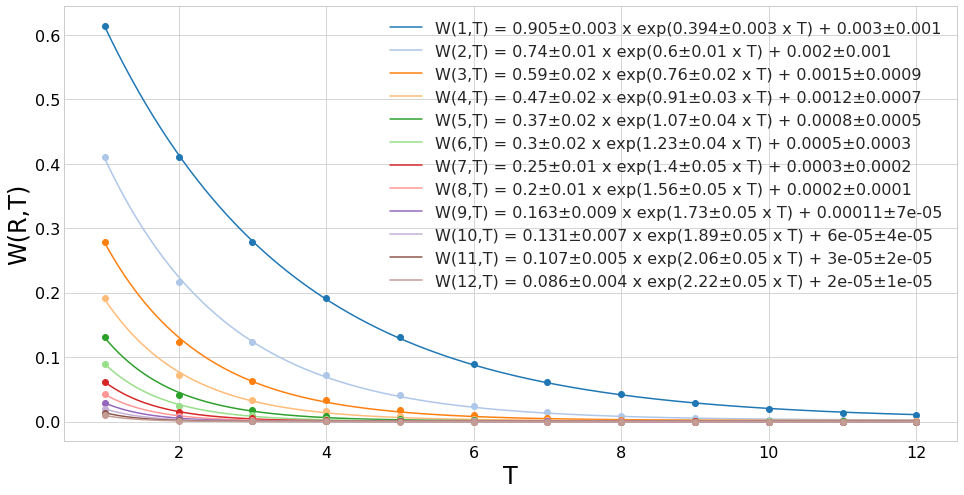

In [12]:
expFits = plotW(data)

### V(R)

In [13]:
def const_func(x, a):
    return np.ones_like(x)*a

In [14]:
t_ranges = {1:(6, 12),
            2:(7, 12),
            3:(5, 10),
            4:(5, 12),
            5:(5, 12),
            6:(6, 12),
            7:(3, 12),
            8:(4, 12),
            9:(4, 12),
            10:(4, 12),
            11:(4, 12),
            12:(3, 12)}

In [15]:
def plotV(data):
    with sns.color_palette('tab20', len(set(data['R']))):
        fits = {}
        for i, r in enumerate(list(set(data['R']))):
            fig = plt.figure(figsize=(16,8))

            #scatter
            cut = (data.R == r) & (data['T'] >= t_ranges[r][0]) & (data['T'] <= t_ranges[r][1]) 
            x = data.loc[cut, 'T'].values[:-1]
            w = data.loc[cut, 'Mean'].values
            err = data.loc[cut, 'Std'].values
            y = np.log([w[j]/w[j+1] for j in range(len(w)-1)])
            y_err = np.sqrt([np.square(err[j]/w[j])+np.square(err[j+1]/w[j+1]) for j in range(len(w)-1)])

            #Nan removal
            skimX = []
            skimY = []
            skimErr = []
            for e in range(len(y)):
                if y[e] == y[e]:
                    skimX.append(x[e])
                    skimY.append(y[e])
                    skimErr.append(y_err[e])

            plt.errorbar(skimX, skimY, yerr=skimErr, fmt='o', color=sns.color_palette()[i], label='')

            #constant fit
            fit, conv = curve_fit(const_func, skimX, skimY, p0=(0.5), sigma=skimErr)
            xx = np.linspace(np.min(skimX), np.max(skimX), 1000)
            yy = const_func(xx, *fit)
            coef = uncertRound(fit[0], np.sqrt(np.diag(conv))[0])
            plt.plot(xx, yy, label=r'$V(' + str(r) + r')=' + str(coef[0]) + r'\pm' + str(coef[1]) + r'$',
                     color=sns.color_palette()[i])

            fits[r] = (fit, conv)

            plt.legend(loc='best', fontsize=16)
            plt.xticks(fontsize=16, color='black')
            plt.yticks(fontsize=16, color='black')
            plt.ylabel(f"V({r})", fontsize=24, color='black')
            plt.xlabel('T', fontsize=24, color='black')
            #plt.yscale('log')
            plt.show()

    return fits

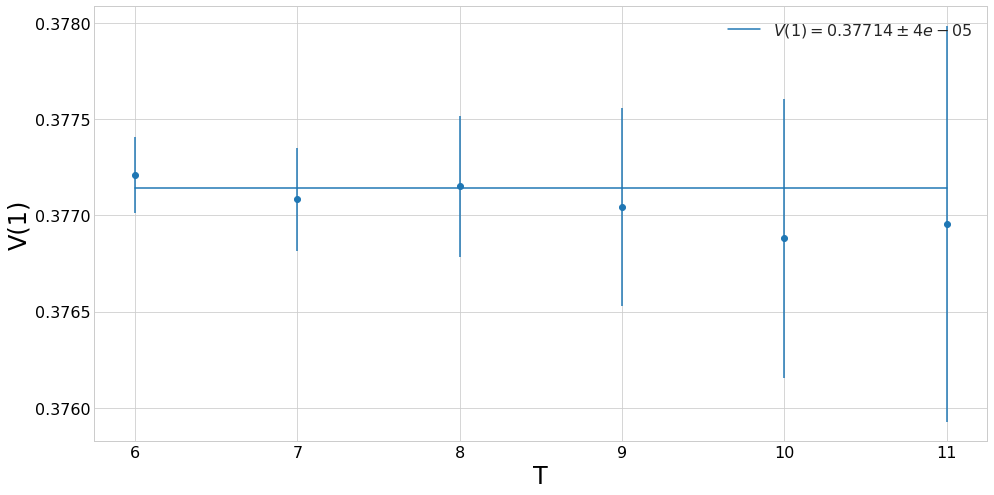

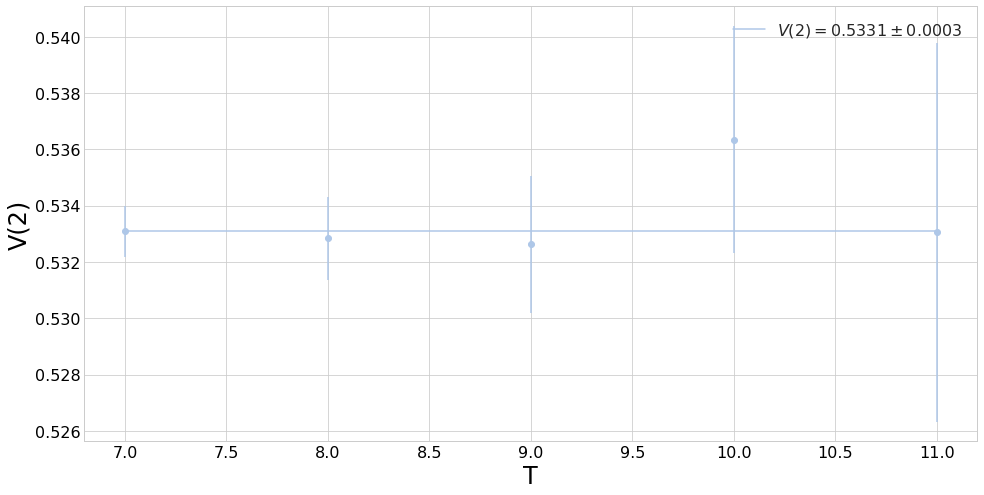

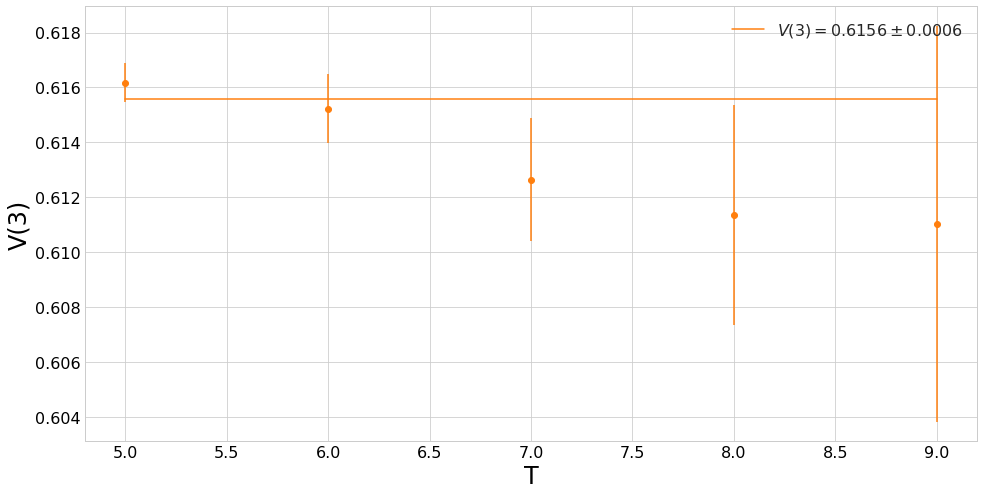

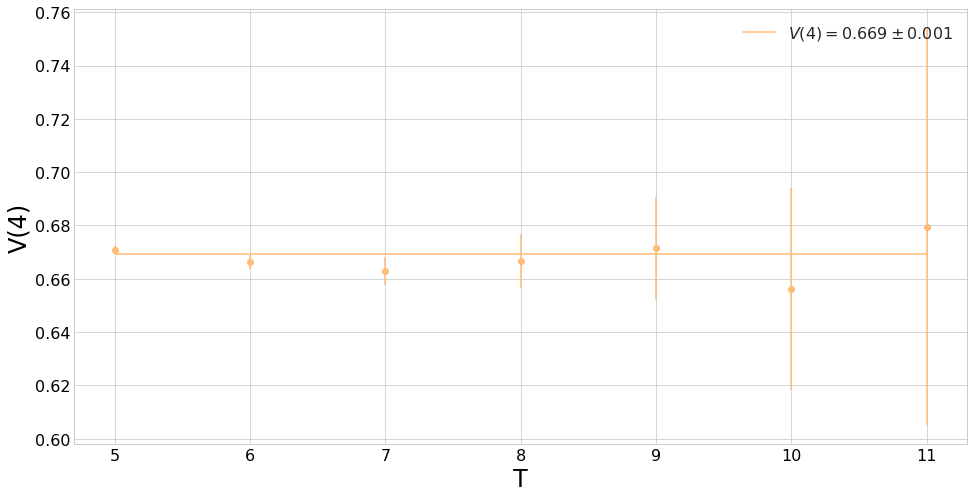

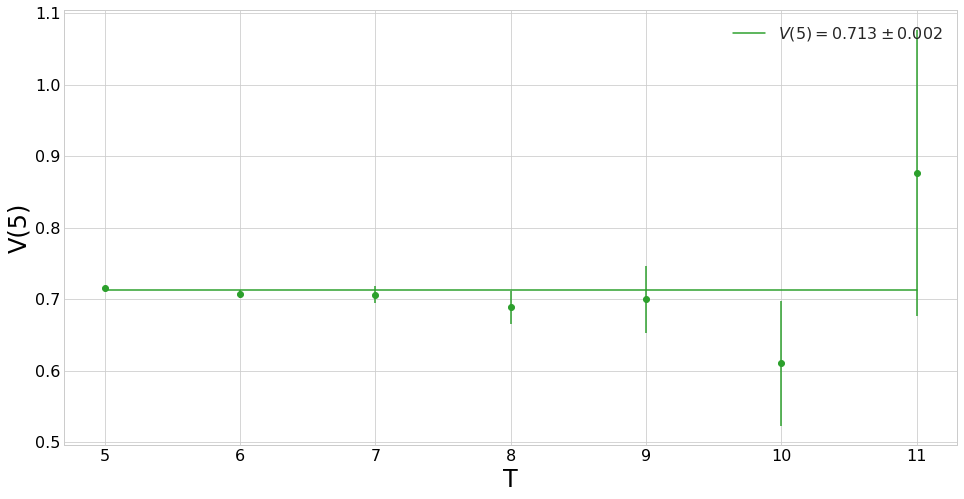

/home/giles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


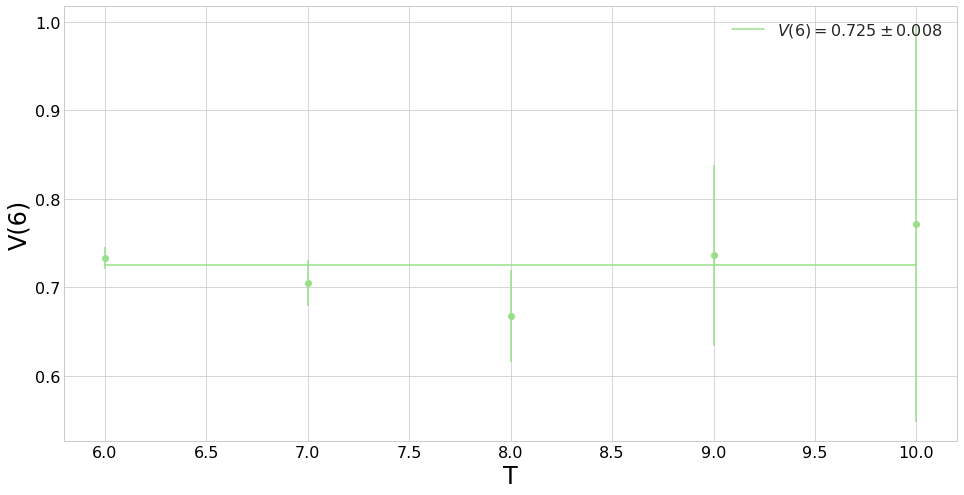

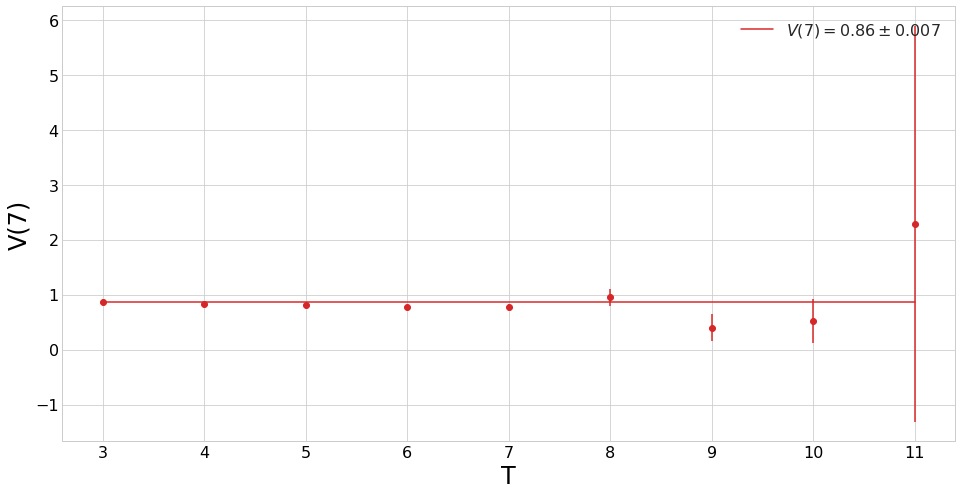

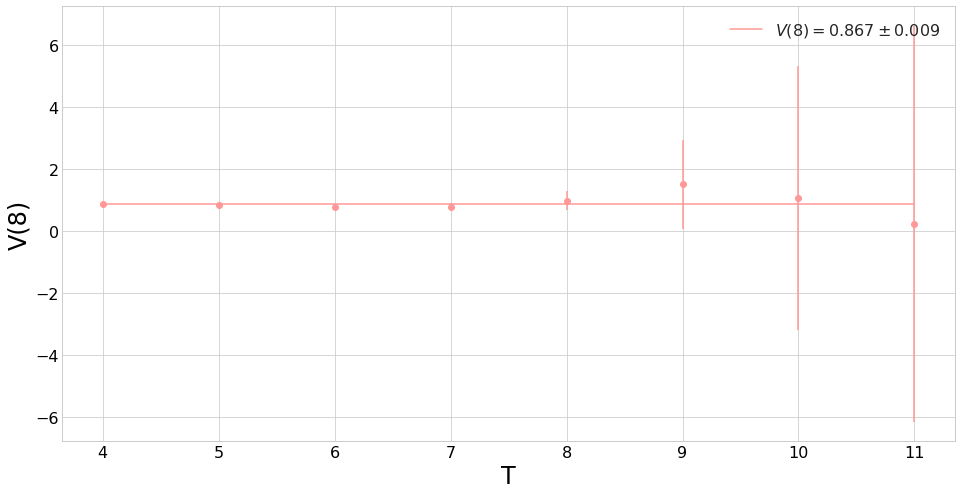

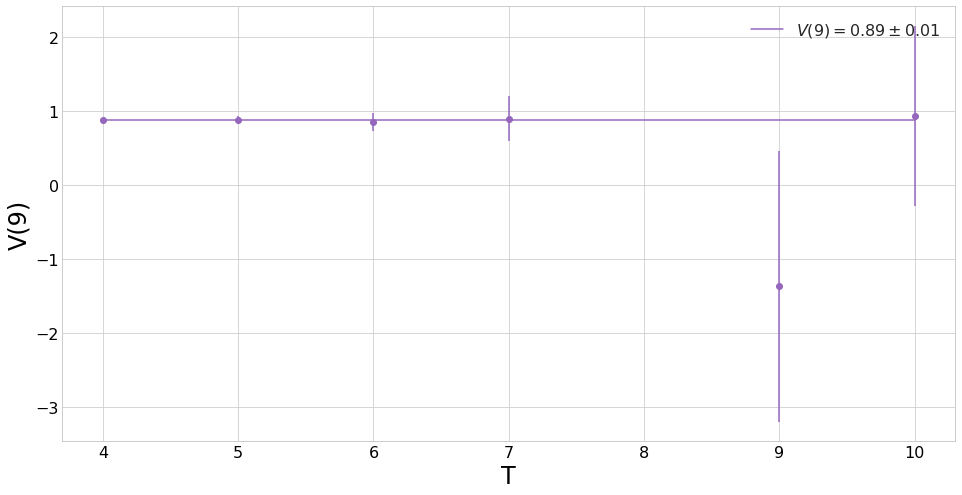

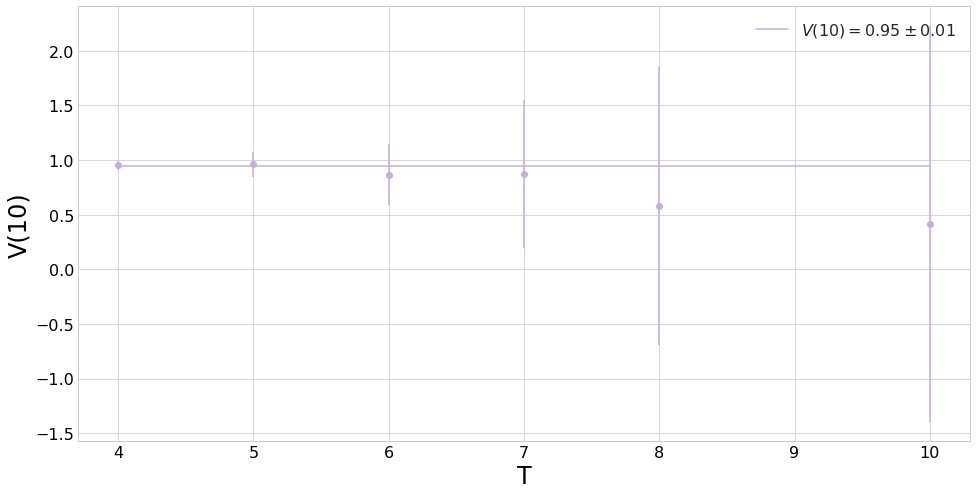

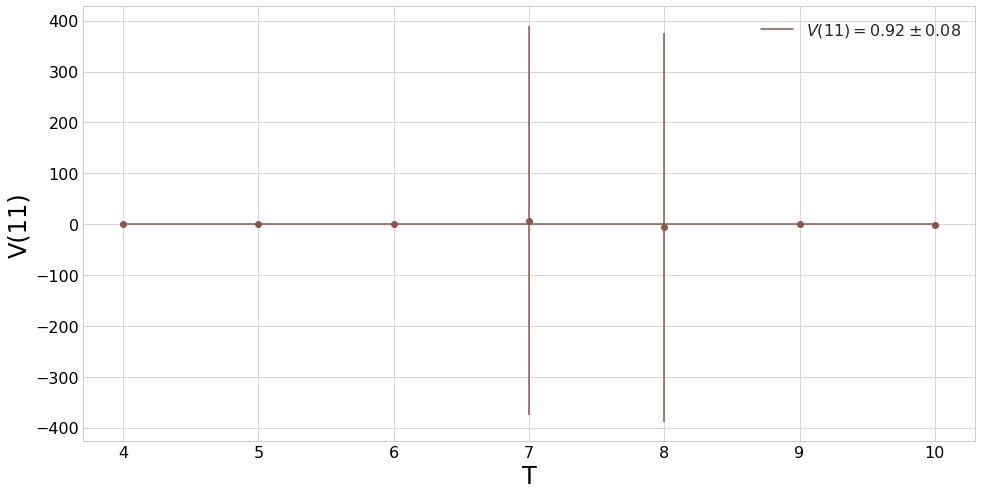

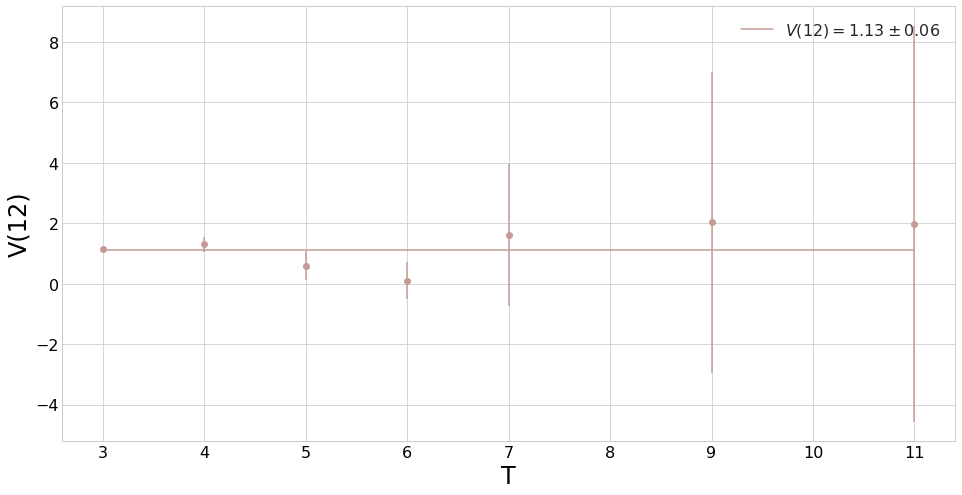

In [16]:
constFits = plotV(data)

In [22]:
def funnel_func(x, a, b, c):
    return (a/x) + b + (c*x)

In [52]:
def plotVR(fits):
    x = np.array([r for r in fits])
    v = [fits[r] for r in fits]
    coefs = np.array([uncertRound(fits[r][0][0], np.sqrt(np.diag(fits[r][1]))[0]) for r in fits])
    
    fig = plt.figure(figsize=(16,8))
    plt.errorbar(x, coefs[:,0], yerr=coefs[:,1], fmt='o', label='', color=sns.color_palette()[0])
    
    #Funnel fit
    fit, conv = curve_fit(funnel_func, x, coefs[:,0], p0=(0.1, 0.4, 0.1), sigma=coefs[:,1])
    xx = np.linspace(np.min(x), np.max(x), 1000)
    yy = funnel_func(xx, *fit)
    
    #Uncertainty
    coef = []
    unc = np.sqrt(np.diag(conv))
    for j in range(len(fit)):
        coef.append(uncertRound(fit[j], unc[j]))
        
    #Chi2
    chi = (coefs[:,0] - funnel_func(x, *fit)) / coefs[:,1]
    chi2 = (chi**2).sum()
    dof = len(x) - len(fit)
    red_chi2 = (chi2 / dof)

    plt.plot(xx, yy, color=sns.color_palette()[0],
             label=r'$V(R) = ' + str(coef[0][0]) + r'\pm' + str(coef[0][1]) + r'\frac{1}{R} + ' \
                   + str(coef[1][0]) + r'\pm' + str(coef[1][1]) \
                   + r'+' + str(coef[2][0]) + r'\pm' + str(coef[2][1]) \
                   + r'\frac{1}{a^2}R,\ \ \ \frac{\chi^2}{N_\mathrm{dof}}=$' + '{:.2f}'.format(red_chi2))
    
    plt.legend(loc='best', fontsize=16)
    plt.xticks(fontsize=16, color='black')
    plt.yticks(fontsize=16, color='black')
    plt.ylabel(f"V(R)", fontsize=24, color='black')
    plt.xlabel('R', fontsize=24, color='black')
    plt.show()

    return fit, conv

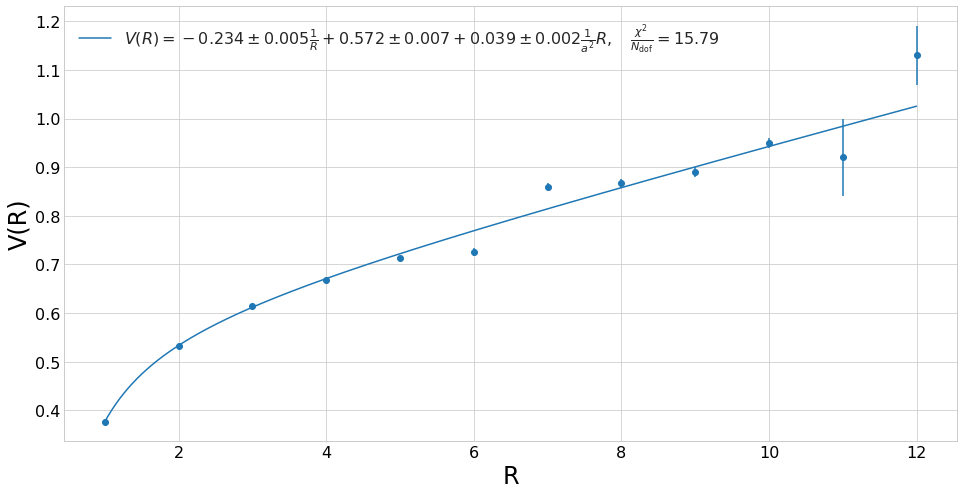

In [53]:
fit, conv = plotVR(constFits)